# Projet 3 : Préparez des données pour un organisme de santé publique

## Contexte

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts, qui est open source afin de permettre à tous de connaitre la qualité nutritionnelle des produits.

Aujourd'hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes.

L'agence Santé publique France confie à notre entreprise la création d'un système de suggestion ou d'auto-complétion pour aider les usagers à remplir plus efficacement la base de données, même si cette dernière venait à être légèrement modifiée.


Notre objectif : nettoyer et explorer les données en interne afin de déterminer la faisabilité de cette idée d'application.s. 

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import pyarrow as pya
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

## Visualisation du tableau de données brutes


In [2]:
# Chargement des données brutes du fichier CSV avec des virgules pour séparateur
data=pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter = '\t')
# Visualisation des 5 premières lignes
data.head(5)

C:\Users\celine.lesur\AppData\Local\Temp\ipykernel_23136\4034584380.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter = '\t')


code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

Les champs sont séparés en quatre sections :

##### Les informations générales sur la fiche du produit :
- code : codebarre du produit ( EAN-13 ou  codes internes pour certains magasins). Pour les produits sans codebarres, Open Food Fact attribue un numéro commençant par le préfixe réservé 200.
- url : url de la page du produit sur Open Food Facts
- creator : contributeur qui a ajouté le produit pour la première fois
- created_t : date à laquelle le produit a été ajouté (timestamp)
- created_datetime : date à laquelle le produit a été ajouté (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- last_modified_t : date à laquelle le produit a été modifié pour la dernière fois (timestamp)
- last_modified_datetime : date à laquelle le produit a été modifié pour la dernière fois (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- product_name : nom du produit
- generic_name : nom générique
- quantity : quantité et unité

##### Un ensemble de tags (catégorie du produit, origine des ingrédients, liste des pays où il est vendu, ...)

##### Les ingrédients composants les produits et leurs additifs éventuels

##### Des informations nutritionnelles (quantité en gramme d'un nutriment pour 100 grammes du produit)

Pour plus d'informations sur les différentes variables : https://world.openfoodfacts.org/data/data-fields.txt

## Etude des données : nombre de lignes & colonnes, types des données et statistiques

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Nous avons donc un data frame composé de 162 variables dont 106 sont des type flottant, et 56 de type objet.
Dans ce data frame, 320771 produits ont été entrés.

Maintenant,recherchons d'éventuels duplicatas en fonction des codebarres produits.

In [4]:
data.duplicated('code').sum()

133

Il existe 133 duplicatas. Etudions les de plus près :

In [5]:
data_dup=data.duplicated('code')
# print(data_dup['data_dup'])
data_dup=np.array(data_dup)
print(type(data_dup))
x= np.where(data_dup == True)[0] # format array
print(x)

data.iloc[x].sort_values(by = 'code').head(133)

<class 'numpy.ndarray'>
[   481    519    560    632   1337   1343   2877   4547   6585   9892
  13067  13384  13391  13392  13394  13395  13396  19029  19063  19064
  20399  21580  21583  22824  27052  34613  34644  51325  62640  64799
  66964  68280  68290  71863  71872  71874  77489  79567  79568  79578
  79579  80834  83154  83165  87709  87711  87732  91156  91723  99206
  99408 101229 101254 120240 120390 120710 122219 126057 128464 128470
 134825 137332 137333 137334 137340 138106 138211 138216 158335 161112
 161115 168878 169195 174391 174392 174596 174719 174721 174990 174991
 175024 175025 175026 175149 175189 175235 176993 177550 177552 189103
 189109 189119 189152 189160 189162 189168 189242 189244 189248 189250
 189260 189262 189269 189272 189345 189362 189364 189379 189404 189406
 189417 229431 237297 237298 237299 251107 262433 263787 263798 263814
 263820 263825 264016 268065 275200 275201 275202 276819 280571 280572
 281938 300376 301337]


code                                                url  \
9892    11778  http://world-fr.openfoodfacts.org/produit/0011...   
481     16117  http://world-fr.openfoodfacts.org/produit/0001...   
519     24600  http://world-fr.openfoodfacts.org/produit/0002...   
560     31233  http://world-fr.openfoodfacts.org/produit/0003...   
632     58001  http://world-fr.openfoodfacts.org/produit/0005...   
...       ...                                                ...   
189364    NaN                                                NaN   
189379    NaN                                                NaN   
189404    NaN                                                NaN   
189406    NaN                                                NaN   
189417    NaN                                                NaN   

                                  creator  \
9892                              beniben   
481                       usda-ndb-import   
519                               tacinte   
560            openfoodfacts-contributors   
632                               kiliweb   
...                                   ...   
189364  villecomtal-sur-arros-gers-france   
189379  villecomtal-sur-arros-gers-france   
189404  villecomtal-sur-arros-gers-france   
189406  villecomtal-sur-arros-gers-france   
189417  villecomtal-sur-arros-gers-france   

                                    created_t      created_datetime  \
9892                               1474489149  2016-09-21T20:19:09Z   
481                                1489065258  2017-03-09T13:14:18Z   
519                                1435406581  2015-06-27T12:03:01Z   
560                                1451914937  2016-01-04T13:42:17Z   
632                                1487432837  2017-02-18T15:47:17Z   
...                                       ...                   ...   
189364                      Courrières,France                  Cora   
189379                                    NaN                   NaN   
189404  Brétigny-sur-Orge,Marseille 5°,France        Auchan,Super U   
189406                    Marseille 5°,France               Super U   
189417                                 France                   NaN   

       last_modified_t    last_modified_datetime  \
9892        1491142385      2017-04-02T14:13:05Z   
481         1489065258      2017-03-09T13:14:18Z   
519         1435406592      2015-06-27T12:03:12Z   
560         1491146137      2017-04-02T15:15:37Z   
632         1487432838      2017-02-18T15:47:18Z   
...                ...                       ...   
189364          France                 en:france   
189379          France                 en:france   
189404   Suisse,France  en:france,en:switzerland   
189406          France                 en:france   
189417          France                 en:france   

                                      product_name  \
9892    All Butter Reduced Fat Stem Ginger Cookies   
481          Colossal Olives With Jalapeno Peppers   
519                                            NaN   
560                 Super chicken spinach & quinoa   
632                          Bramley Apple Crumble   
...                                            ...   
189364                                      France   
189379                                      France   
189404                               France,Suisse   
189406                                      France   
189417                                      France   

                                             generic_name  \
9892                                                  NaN   
481                                                   NaN   
519                                                   NaN   
560                                                   NaN   
632                                                   NaN   
...                                                   ...   
189364                                                NaN   
189379  _Lait_ entier (78,1%), sucre

In [6]:
data.loc[data['code']==16117]

code                                                url  \
6    16117  http://world-fr.openfoodfacts.org/produit/0000...   
481  16117  http://world-fr.openfoodfacts.org/produit/0001...   

             creator   created_t      created_datetime last_modified_t  \
6    usda-ndb-import  1489055730  2017-03-09T10:35:30Z      1489055730   
481  usda-ndb-import  1489065258  2017-03-09T13:14:18Z      1489065258   

    last_modified_datetime                           product_name  \
6     2017-03-09T10:35:30Z          Organic Long Grain White Rice   
481   2017-03-09T13:14:18Z  Colossal Olives With Jalapeno Peppers   

    generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
6            NaN      NaN  ...     NaN                         NaN   
481          NaN      NaN  ...     NaN                         NaN   

    collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
6                                NaN        NaN             NaN   
481                              NaN        NaN             NaN   

    carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
6                     NaN                     NaN                     NaN   
481                   NaN                     NaN                     NaN   

    glycemic-index_100g water-hardness_100g  
6                   NaN                 NaN  
481                 NaN                 NaN  

[2 rows x 162 columns]

Un codebarre dupliqué ne correspond pas au même produit(product_name). Nous ne pouvons donc pas considérer ces duplicatas comme des doublons. Au vu de la petite quantité, nous les gardons dans la base de données pour l'analyse.

Tentons d'alleger la base de données, en ne gardant que les colonnes pertinentes pour l'analyse et commençons par supprimer les colonnes qui ont plus de 70% de valeurs manquantes:


In [7]:
#  Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables et de filtrer sur les variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent

def show_miss_val(data,percent):  
    variables = []
    miss_val = []
    
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    return output[output['miss_val']>=percent].sort_values('miss_val')

In [8]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable avec un filtre de 0.7 pour n'avoir que les colonnes avec plus de 70% de valeurs manquantes
data_vm=show_miss_val(data,0.7)
data_vm.head(120)

variable  miss_val
55         pnns_groups_2  0.705426
54         pnns_groups_1  0.714710
16         categories_fr  0.736850
14            categories  0.736854
15       categories_tags  0.736919
..                   ...       ...
94     elaidic-acid_100g  1.000000
98    nervonic-acid_100g  1.000000
97      erucic-acid_100g  1.000000
52    nutrition_grade_uk  1.000000
161  water-hardness_100g  1.000000

[119 rows x 2 columns]

Supprimons ces 119 variables et regardonc ce qu'il nous reste :

In [9]:
#  Fonction permettant de supprimer les variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent

def del_miss_val(data,percent):  
    variables = []
    miss_val = []
    del_var=[]
    
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    del_output = output[output['miss_val']>=percent]
    for item in del_output['variable'] :
        del_var.append(item)
    output_afterdrop = data.drop(columns=del_var, axis = 1)
    return output_afterdrop


In [10]:
#  Appel de la fonction supprimant les colonnes avec plus de 70% de valeurs manquantes

data_clean=del_miss_val(data,0.7)    
data_clean.head(10)


code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   
5  16100  http://world-fr.openfoodfacts.org/produit/0000...   
6  16117  http://world-fr.openfoodfacts.org/produit/0000...   
7  16124  http://world-fr.openfoodfacts.org/produit/0000...   
8  16193  http://world-fr.openfoodfacts.org/produit/0000...   
9  16513  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   
5             usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
6             usda-ndb-import  1489055730  2017-03-09T10:35:30Z   
7             usda-ndb-import  1489055711  2017-03-09T10:35:11Z   
8             usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
9             usda-ndb-import  1489055654  2017-03-09T10:34:14Z   

  last_modified_t last_modified_datetime                       product_name  \
0      1474103893   2016-09-17T09:18:13Z                 Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z     Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                            Peanuts   
3      1489055731   2017-03-09T10:35:31Z             Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                    Organic Polenta   
5      1489055651   2017-03-09T10:34:11Z  Breadshop Honey Gone Nuts Granola   
6      1489055730   2017-03-09T10:35:30Z      Organic Long Grain White Rice   
7      1489055712   2017-03-09T10:35:12Z                     Organic Muesli   
8      1489055651   2017-03-09T10:34:11Z       Organic Dark Chocolate Minis   
9      1489055654   2017-03-09T10:34:14Z              Organic Sunflower Oil   

  quantity                brands  ... fiber_100g proteins_100g salt_100g  \
0      1kg       Ferme t'y R'nao  ...        NaN           NaN       NaN   
1      NaN                   NaN  ...        3.6          3.57   0.00000   
2      NaN        Torn & Glasser  ...        7.1         17.86   0.63500   
3      NaN             Grizzlies  ...        7.1         17.86   1.22428   
4      NaN        Bob's Red Mill  ...        5.7          8.57       NaN   
5      NaN                  Unfi  ...        7.7         13.46       NaN   
6      NaN              Lundberg  ...        NaN          8.89       NaN   
7      NaN        Daddy's Muesli  ...        9.4         14.06   0.13970   
8      NaN        Equal Exchange  ...        7.5          5.00       NaN   
9      NaN  Napa Valley Naturals  ...        NaN           NaN       NaN   

  sodium_100g vitamin-a_100g vitamin-c_100g  calcium_100g iron_100g  \
0         NaN            NaN            NaN           NaN       NaN   
1       0.000            0.0         0.0214         0.000   0.00129   
2       0.250            0.0         0.0000         0.071   0.00129   
3       0.482            NaN            NaN         0.143   0.00514   
4         NaN            NaN            NaN           NaN       NaN   
5         NaN            NaN            NaN         0.038   0.00346   
6         NaN            NaN         0.0027         0.044       NaN   
7       0.055            NaN            NaN         0.062   0.00422   
8         NaN            NaN            NaN         0.050   0.01125   
9         NaN            NaN            NaN           NaN       NaN   

  nutrition-score-fr_100g nutrition-score-uk_100g  
0                     NaN      

Il nous reste 43 colonnes/variables avec moins de 70% de valeurs manquantes et qui sont donc pertinentes pour notre analyse

Continuons à réduire notre champ d'analyse : 
- dans la fiche produit, seul le nom du produit et sa quantité peuvent être intéressante.

Supprimons donc les 7 premières colonnes/variables :

In [11]:
df=data_clean.columns
del_var=[]
for item in df[:7] :
        del_var.append(item)
data_clean = data_clean.drop(columns=del_var, axis = 1)
data_clean.head()


product_name quantity           brands      brands_tags  \
0              Farine de blé noir      1kg  Ferme t'y R'nao  ferme-t-y-r-nao   
1  Banana Chips Sweetened (Whole)      NaN              NaN              NaN   
2                         Peanuts      NaN   Torn & Glasser     torn-glasser   
3          Organic Salted Nut Mix      NaN        Grizzlies        grizzlies   
4                 Organic Polenta      NaN   Bob's Red Mill   bob-s-red-mill   

  countries    countries_tags countries_fr  \
0     en:FR         en:france       France   
1        US  en:united-states   États-Unis   
2        US  en:united-states   États-Unis   
3        US  en:united-states   États-Unis   
4        US  en:united-states   États-Unis   

                                    ingredients_text     serving_size  \
0                                                NaN              NaN   
1  Bananas, vegetable oil (coconut oil, corn oil ...     28 g (1 ONZ)   
2  Peanuts, wheat flour, sugar, rice flour, tapio...  28 g (0.25 cup)   
3  Organic hazelnuts, organic cashews, organic wa...  28 g (0.25 cup)   
4                                    Organic polenta  35 g (0.25 cup)   

   additives_n  ... fiber_100g proteins_100g salt_100g  sodium_100g  \
0          NaN  ...        NaN           NaN       NaN          NaN   
1          0.0  ...        3.6          3.57   0.00000        0.000   
2          0.0  ...        7.1         17.86   0.63500        0.250   
3          0.0  ...        7.1         17.86   1.22428        0.482   
4          0.0  ...        5.7          8.57       NaN          NaN   

   vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0             NaN            NaN          NaN       NaN   
1             0.0         0.0214        0.000   0.00129   
2             0.0         0.0000        0.071   0.00129   
3             NaN            NaN        0.143   0.00514   
4             NaN            NaN          NaN       NaN   

  nutrition-score-fr_100g  nutrition-score-uk_100g  
0                     NaN                      NaN  
1                    14.0                     14.0  
2                     0.0                      0.0  
3                    12.0                     12.0  
4                     NaN                      NaN  

[5 rows x 36 columns]

Nous avons dorénavant un dataframe avec 36 variables à étudier.

Regardons notre dataframe épuré en détails :

In [12]:
#  Variables quantitatives :
data_clean.describe()

additives_n  ingredients_from_palm_oil_n  \
count  248939.000000                248939.000000   
mean        1.936024                     0.019659   
std         2.502019                     0.140524   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        31.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n   energy_100g       fat_100g  \
count                            248939.000000  2.611130e+05  243891.000000   
mean                                  0.055246  1.141915e+03      12.730379   
std                                   0.269207  6.447154e+03      17.578747   
min                                   0.000000  0.000000e+00       0.000000   
25%                                   0.000000  3.770000e+02       0.000000   
50%                                   0.000000  1.100000e+03       5.000000   
75%                                   0.000000  1.674000e+03      20.000000   
max                                   6.000000  3.251373e+06     714.290000   

       saturated-fat_100g  trans-fat_100g  cholesterol_100g  \
count       229554.000000   143298.000000     144090.000000   
mean             5.129932        0.073476          0.020071   
std              8.014238        1.540223          0.358062   
min              0.000000       -3.570000          0.000000   
25%              0.000000        0.000000          0.000000   
50%              1.790000        0.000000          0.000000   
75%              7.140000        0.000000          0.020000   
max            550.000000      369.000000         95.238000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       243588.000000  244971.000000  200886.000000  259922.000000   
mean            32.073981      16.003484       2.862111       7.075940   
std             29.731719      22.327284      12.867578       8.409054   
min              0.000000     -17.860000      -6.700000    -800.000000   
25%              6.000000       1.300000       0.000000       0.700000   
50%             20.600000       5.710000       1.500000       4.760000   
75%             58.330000      24.000000       3.600000      10.000000   
max           2916.670000    3520.000000    5380.000000     430.000000   

           salt_100g    sodium_100g  vitamin-a_100g  vitamin-c_100g  \
count  255510.000000  255463.000000   137554.000000   140867.000000   
mean        2.028624       0.798815        0.000397        0.023367   
std       128.269454      50.504428        0.073278        2.236451   
min         0.000000       0.000000       -0.000340       -0.002100   
25%         0.063500       0.025000        0.000000        0.000000   
50%         0.581660       0.229000        0.000000        0.000000   
75%         1.374140       0.541000        0.000107        0.003700   
max     64312.800000   25320.000000       26.700000      716.981100   

        calcium_100g      iron_100g  nutrition-score-fr_100g  \
count  141050.000000  140462.000000            221210.000000   
mean        0.125163       0.003652                 9.165535   
std         3.318263       0.214408                 9.055903   
min         0.000000      -0.000260               -15.000000   
25%         0.000000       0.000000                 1.000000   
50%         0.035000       0.001010                10.000000   
75%         0.106000       0.002400                16.000000   
max       694.737000      50.000000                40.000000   

       nutrition-score-uk_100g  
count            221210.000000  
mean                  9.058049  
std                   9.183589  
min                 -15.000000  
25%                   1.000000  
50%                   9.000000  
75%                  16.000000  
max                  40.000000

In [13]:
#  Variables qualitatives :
data_clean.describe(exclude=[np.number])

product_name quantity     brands brands_tags countries  \
count        303010   104819     292360      292352    320492   
unique       221347    13826      58784       50253      1434   
top       Ice Cream    500 g  Carrefour   carrefour        US   
freq            410     4669       2978        3149    169928   

          countries_tags countries_fr                   ingredients_text  \
count             320492       320492                             248962   
unique               725          722                             205520   
top     en:united-states   États-Unis  Carbonated water, natural flavor.   
freq              172998       172998                                222   

            serving_size                                          additives  \
count             211331                                             248905   
unique             25423                                             196069   
top     240 ml (8 fl oz)   [ extra-virgin-olive-oil -> en:extra-virgin-o...   
freq                5496                                                397   

       additives_tags       additives_fr nutrition_grade_fr  \
count          154680             154680             221210   
unique          41537              41537                  5   
top           en:e322  E322 - Lécithines                  d   
freq             8264               8264              62763   

                                                   states  \
count                                              320726   
unique                                               1021   
top     en:to-be-completed, en:nutrition-facts-complet...   
freq                                               168905   

                                              states_tags  \
count                                              320726   
unique                                               1021   
top     en:to-be-completed,en:nutrition-facts-complete...   
freq                                               168905   

                                                states_fr  
count                                              320726  
unique                                               1021  
top     A compléter,Informations nutritionnelles compl...  
freq                                               168905

Nous pouvons observer des valeurs aberrantes pour les variables quantitatives. Toutes les variables qui finissent par '_100g' sont exprimés en g (excepté pour l'energie, en KJ) et ne peuvent donc pas dépasser 100g dans 100g de produit. Les valeurs de ces variables ne peuvent pas non plus être négatives.

Excepté pour l'energie qui n'est pas exprimé dans la même unité, imputons en Nan toutes les valeurs négatives ou supérieures à 100 pour les variables finissant par '_100g'.

In [14]:
# Imputation des valeur aberrantes en Nan
variables = ['fat_100g','saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g','carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g','salt_100g', 'sodium_100g', 'vitamin-a_100g','vitamin-c_100g','calcium_100g', 'iron_100g']
for item in variables :
    data_clean.loc[(data[item]<0) |(data[item]>100), item]= np.nan

# Nouvelles statistiques des colonnes quantitatives sans les valeurs aberrantes
data_clean.describe()

additives_n  ingredients_from_palm_oil_n  \
count  248939.000000                248939.000000   
mean        1.936024                     0.019659   
std         2.502019                     0.140524   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        31.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n   energy_100g       fat_100g  \
count                            248939.000000  2.611130e+05  243887.000000   
mean                                  0.055246  1.141915e+03      12.725256   
std                                   0.269207  6.447154e+03      17.503695   
min                                   0.000000  0.000000e+00       0.000000   
25%                                   0.000000  3.770000e+02       0.000000   
50%                                   0.000000  1.100000e+03       5.000000   
75%                                   0.000000  1.674000e+03      20.000000   
max                                   6.000000  3.251373e+06     100.000000   

       saturated-fat_100g  trans-fat_100g  cholesterol_100g  \
count       229551.000000   143289.000000     144090.000000   
mean             5.125925        0.067172          0.020071   
std              7.913684        0.945020          0.358062   
min              0.000000        0.000000          0.000000   
25%              0.000000        0.000000          0.000000   
50%              1.790000        0.000000          0.000000   
75%              7.140000        0.000000          0.020000   
max            100.000000      100.000000         95.238000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       243569.000000  244952.000000  200881.000000  259918.000000   
mean            32.055323      15.985449       2.832473       7.079409   
std             29.140680      21.165362       4.588272       8.156552   
min              0.000000       0.000000       0.000000       0.000000   
25%              6.000000       1.300000       0.000000       0.700000   
50%             20.600000       5.710000       1.500000       4.760000   
75%             58.330000      24.000000       3.600000      10.000000   
max            100.000000     100.000000     100.000000     100.000000   

           salt_100g    sodium_100g  vitamin-a_100g  vitamin-c_100g  \
count  255352.000000  255429.000000   137553.000000   140863.000000   
mean        1.588497       0.647145        0.000397        0.014563   
std         6.242531       2.656343        0.073279        0.461423   
min         0.000000       0.000000        0.000000        0.000000   
25%         0.063500       0.025000        0.000000        0.000000   
50%         0.580000       0.229000        0.000000        0.000000   
75%         1.371600       0.541000        0.000107        0.003700   
max       100.000000     100.000000       26.700000      100.000000   

        calcium_100g      iron_100g  nutrition-score-fr_100g  \
count  141040.000000  140461.000000            221210.000000   
mean        0.102023       0.003653                 9.165535   
std         0.585288       0.214409                 9.055903   
min         0.000000       0.000000               -15.000000   
25%         0.000000       0.000000                 1.000000   
50%         0.035000       0.001010                10.000000   
75%         0.106000       0.002400                16.000000   
max        99.006000      50.000000                40.000000   

       nutrition-score-uk_100g  
count            221210.000000  
mean                  9.058049  
std                   9.183589  
min                 -15.000000  
25%                   1.000000  
50%                   9.000000  
75%                  16.000000  
max                  40.000000

Construisons maintenant la matrice de corrélations pour définir des relations entre les variables :

In [15]:
# Fonction permettant de ne garder que les variables quantitatives du Dataframe
def col_quant (data) :
    del_var=[]
    variables = data.columns
    for item in variables :
        if data[item].dtypes == 'object' :
            del_var.append(item)
    output = data.drop(columns=del_var, axis = 1)
    return output

In [16]:
data_quant=col_quant(data_clean)
corr=data_quant.corr()
fig = plt.figure(figsize=(30,30), dpi = 400)
sns.heatmap(corr,cmap='coolwarm',annot=True,linewidth=0.9)
plt.show()

Nous observons :
 - une corrélation parfaite entre le sel et le sodium qui était attendue, l'analyse d'une seule de ces variables sera pertinente
 - une corrélation quasiment parfaite entre le nutriscore français et anglais
 - les deux graisses (saturés ou non) sont fortement corrélées et sont toutes deux corrélées aux deux nutriscores
 - le sucre et les carbohydrates sont fortement corrélés entre eux et sont tous deux légèrement corrélés aux deux nutriscores
 - le calcium et la vitamine A sont corrélés
 - Aucune anti-corrélation prononcée n'apparait

Si nous nous concentrons uniquement sur ces variables :

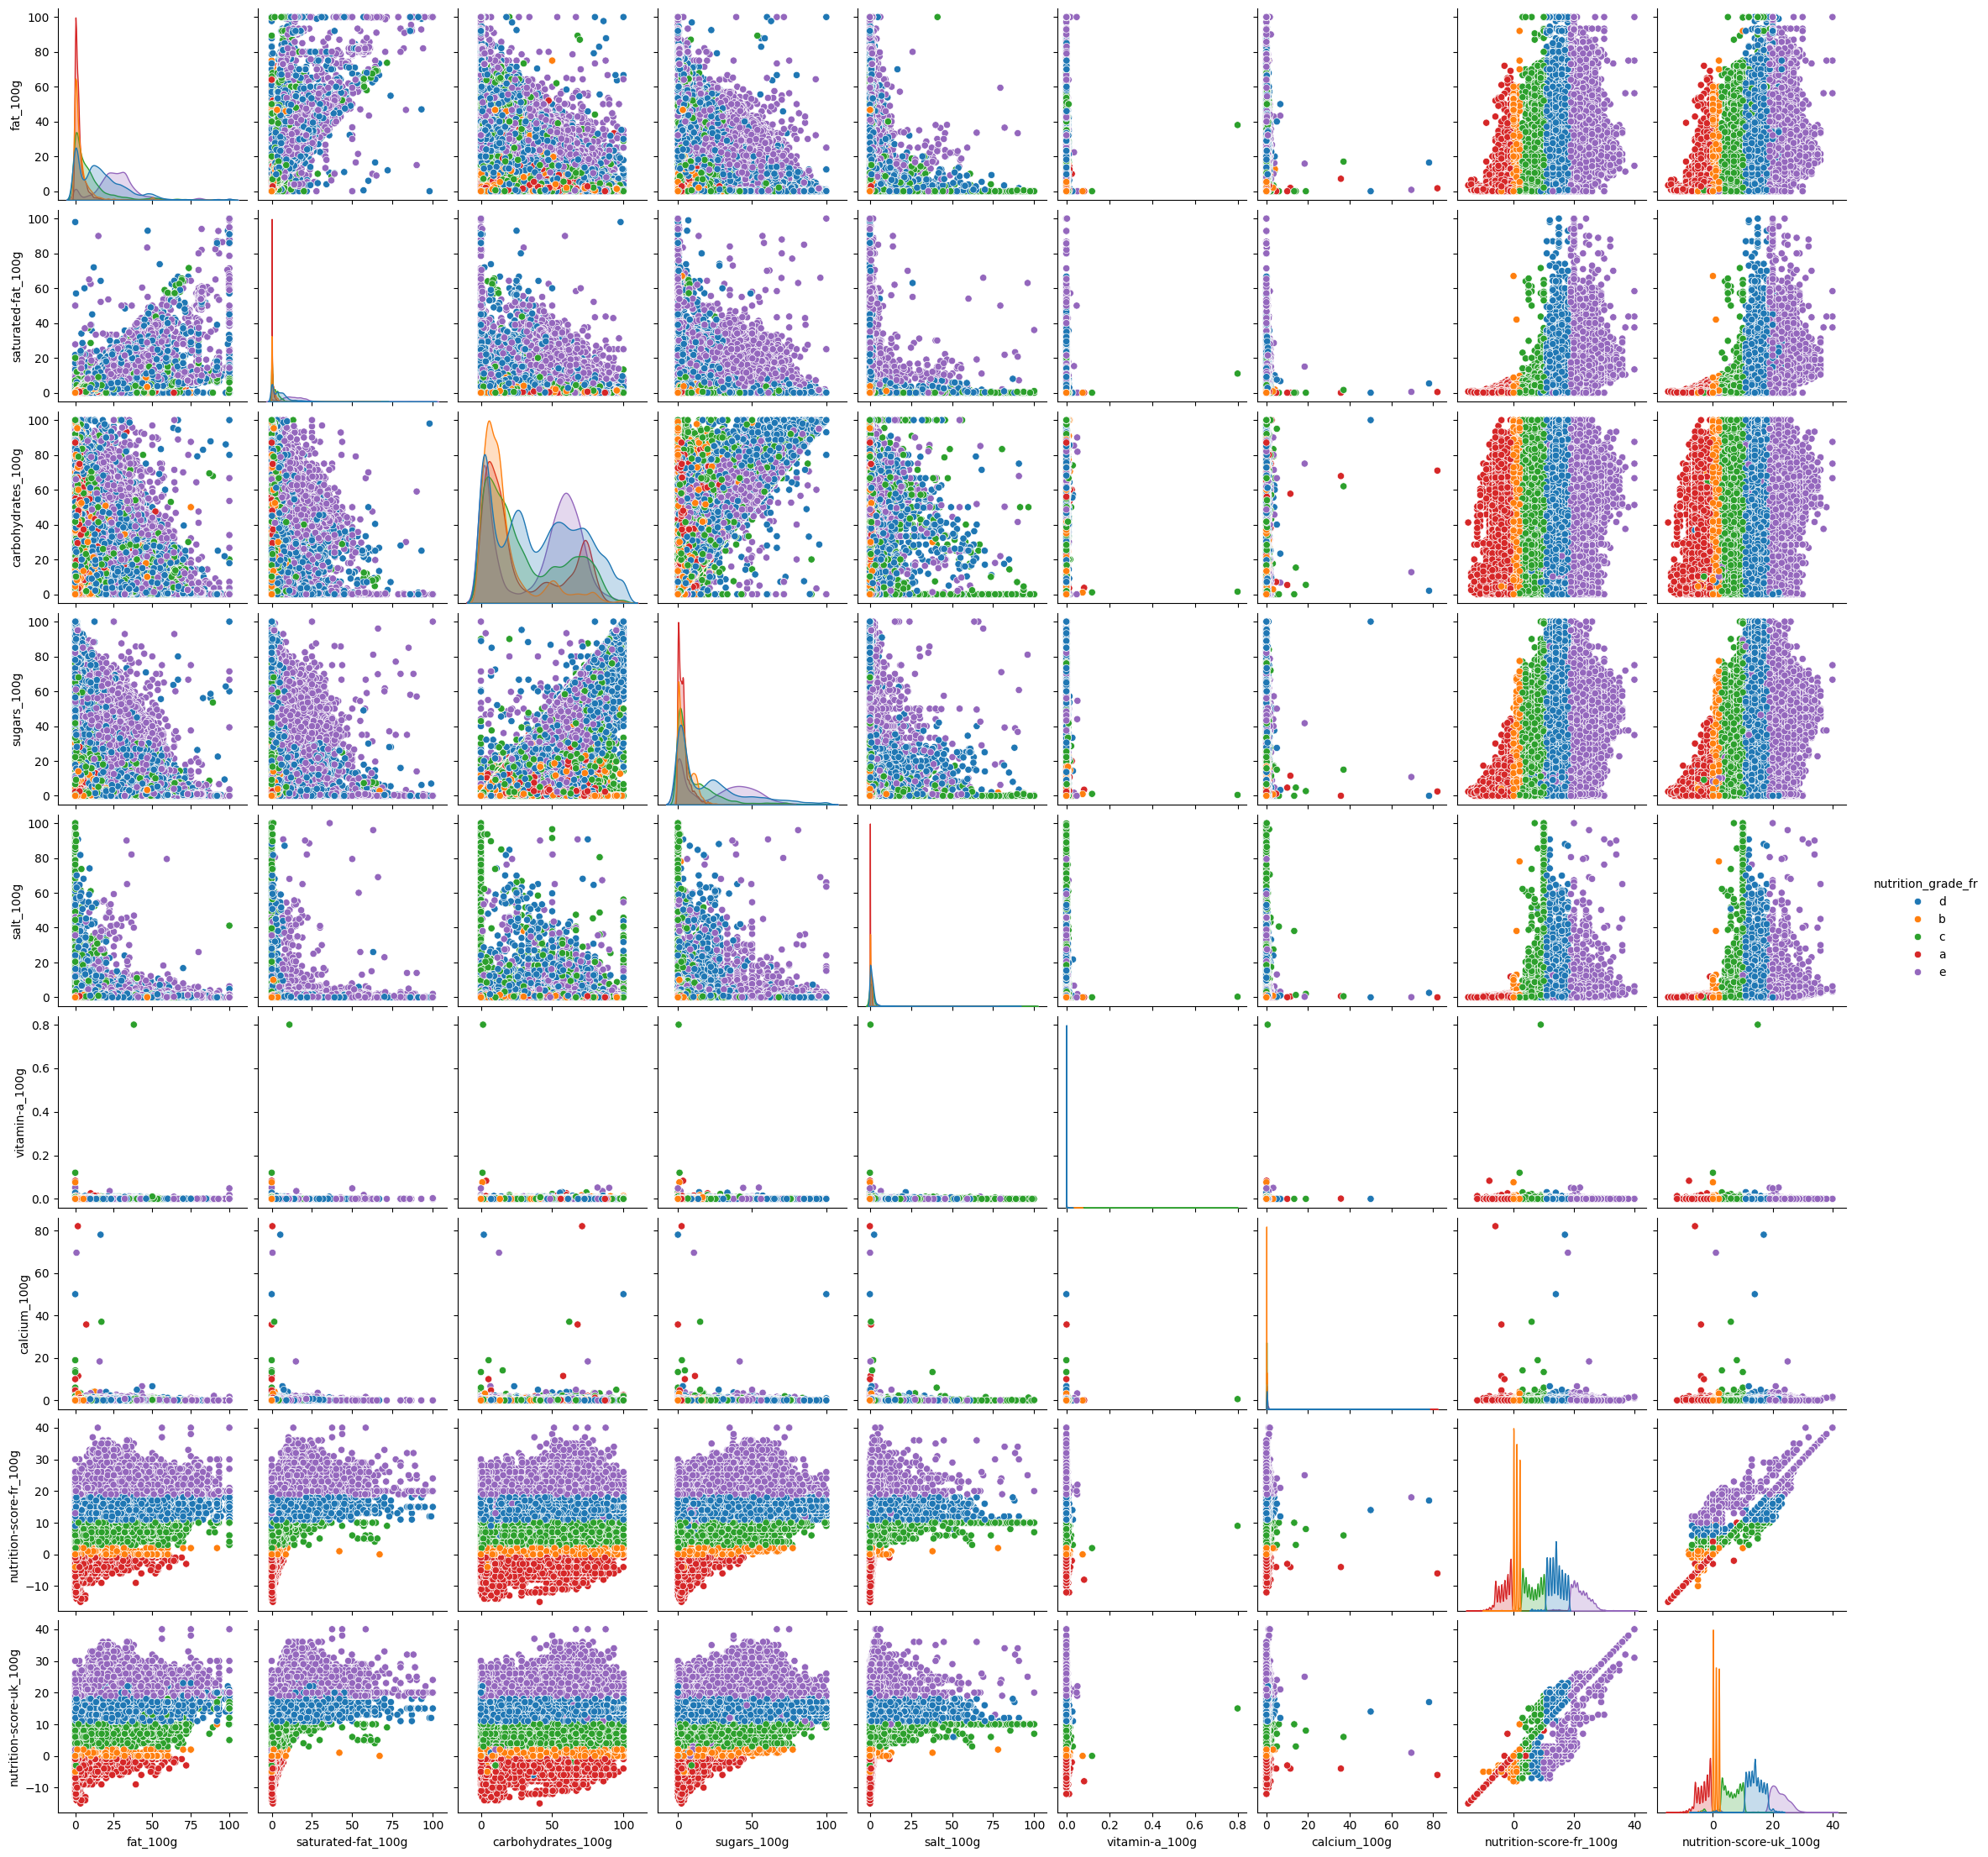

<Figure size 2385.74x2250 with 0 Axes>

In [17]:
variable=['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','salt_100g','vitamin-a_100g','calcium_100g','nutrition-score-fr_100g','nutrition-score-uk_100g','nutrition_grade_fr']
data_quant_corr = data_clean[variable]
sns_plot = sns.pairplot(data_quant_corr, hue="nutrition_grade_fr")
sns_plot.savefig("pairplot.png")
plt.clf() # Clean pairplot figure
Image(filename='pairplot.png') # Création de l'image PNG

On retrouve les résultats de la matrice de corrélations.

Pas d'informations complémentaires en les traçant en fonction du nutriscore.

C:\Users\celine.lesur\AppData\Local\Temp\ipykernel_23136\3875330101.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_clean,x=variable, y=data_clean["nutrition_grade_fr"], color=color, ax=axes, palette="Paired",gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
C:\Users\celine.lesur\AppData\Local\Temp\ipykernel_23136\3875330101.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_clean,x=variable, y=data_clean["nutrition_grade_fr"], color=color, ax=axes, palette="Paired",gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
C:\Users\celine.lesur\AppData\Local\Temp\ipykernel_23136\3875330101.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

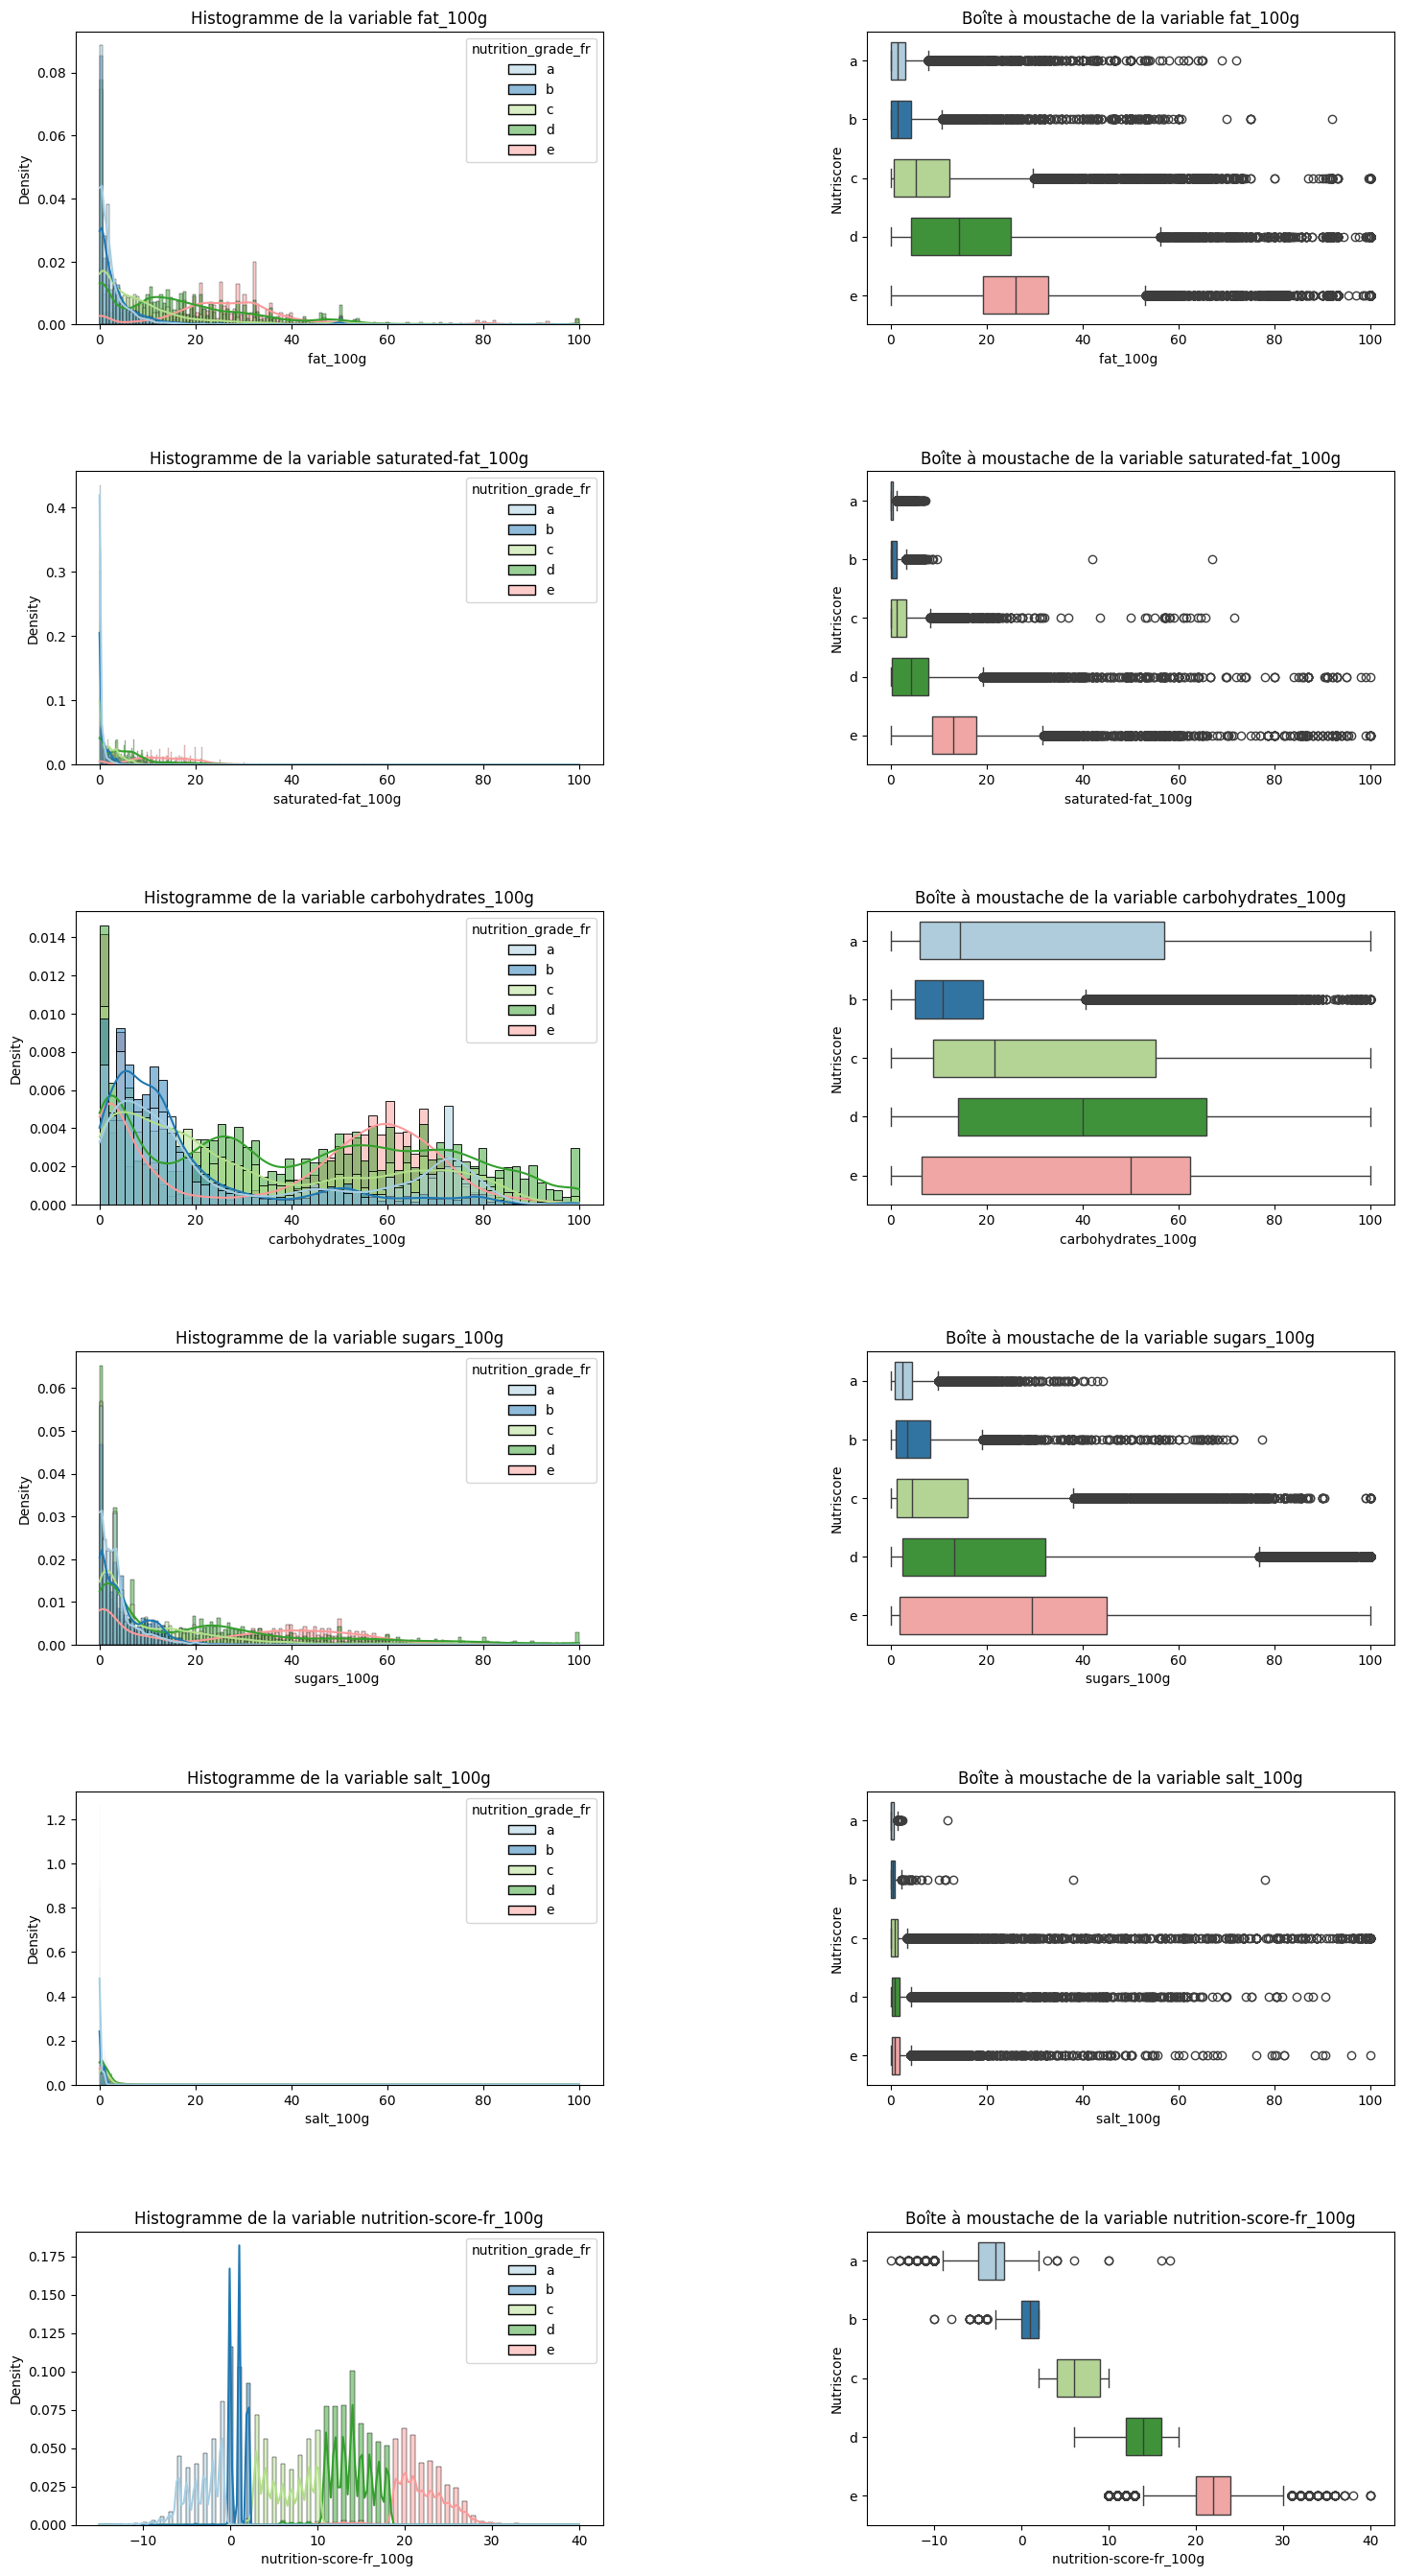

In [18]:
# Liste des variables à visualiser et leurs informations associées
variables=[('fat_100g','blue',1),('saturated-fat_100g','green',3),('carbohydrates_100g','red',5),('sugars_100g','black',7),('salt_100g','orange',9),('nutrition-score-fr_100g','purple',11)]
hue_order = ['a', 'b', 'c','d','e']
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(6, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", hue="nutrition_grade_fr", palette="Paired",hue_order=hue_order)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(6, 2, place)
    sns.boxplot(data=data_clean,x=variable, y=data_clean["nutrition_grade_fr"], color=color, ax=axes, palette="Paired",gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")
    plt.ylabel(f"Nutriscore")

Sur les boites à moustaches, nous observons des valeurs atypiques pour la majorité de ces variables. 
Il semble difficile de pouvoir dire si ces valeurs atypiques sont aberrantes ou non sans être un expert et regarder chaque produit un par un.
Seules les valeurs atypiques liées au nutriscore peuvent être expliquées :
- Les valeurs atypiques liées au nutriscore "e" semblent corrects car dans la méthode de calcul du nutriscore les boissons sont catégorisées "e" à partir d'un nutriscore de 10.

In [19]:
data_vm=show_miss_val(data,0.5)
data_vm.head(120)

variable  miss_val
45                            additives_fr  0.517788
44                          additives_tags  0.517788
100                       cholesterol_100g  0.550802
99                          trans-fat_100g  0.553271
138                           calcium_100g  0.560280
..                                     ...       ...
50   ingredients_that_may_be_from_palm_oil  1.000000
52                      nutrition_grade_uk  1.000000
67                       butyric-acid_100g  1.000000
68                       caproic-acid_100g  1.000000
98                      nervonic-acid_100g  1.000000

[120 rows x 2 columns]

In [20]:
# Fonction permettant de remplacer les valeurs manquantes d'une colonne par une deuxième et de supprimer la deuxième colonne
def rempl_missing_value(df,col1,col2) :
    variables = [col1, col2]
    df2=df[variables].isna()
    df_missing_name=df2.loc[(df2['product_name']==True) & (df2['generic_name']==False)]
    df_missing_name_index=df_missing_name.index.to_list()
    for i in df_missing_name_index :
        df.loc[i,col1] = df.loc[i,col2]    
    return df.drop([col2], axis=1)
            

In [21]:
# On appelle la fonction pour créer un nouveau dataframe nettoyé 
data_clean = rempl_missing_value(data,'product_name','generic_name')


En ce qui concerne les informations nutritionnelles, il parait assez logique de mettre à 0 les valeurs manquantes en considérant que si cela n'a pas été rempli c'est que la valeur est nulle.

In [22]:
# Imputation des valeur  Nan à 0 pour les informations nutritionnelles
data.iloc[:,63]

0            NaN
1         2243.0
2         1941.0
3         2540.0
4         1552.0
           ...  
320767       NaN
320768       0.0
320769       NaN
320770       NaN
320771    2092.0
Name: energy_100g, Length: 320772, dtype: float64


Liste des étapes:
- suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.
- Repérer des variables pertinentes pour les traitements à venir, et nécessaires pour suggérer des valeurs manquantes,.
- Nettoyer les données en mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
(imputation par 0, moyenne, médiane OU estimation avec ML de type KNN OU estimation via iterative imputer (pertinente que sur des variables corrélées entre elles)
- en identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.
- Automatiser ces traitements pour éviter de répéter ces opérations

- Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données et de les expliquer  à un public néophyte (attention à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…)).
- Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement + graphiques variables catégorielles et numériques
- Effectuer une analyse bivariée avec matrice de corrélations + graphiques croisant 2 variables numériques OU une numérique et une catégorielle
- Sélectionner / créer des variables à l’aide d’une analyse multivariée. Analyse descriptive en Composante Principale (ACP) / Analyse explicative ANOVA
Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats + graphiques (ex : repartition du nutriscore, nb d'articles vendus dans chaque pays,...)

- Rédiger un rapport d’exploration et une conclusion pour expliquer la faisabilité de l’application demandée.

- Même si les données n’incluent pas de données personnelles, on doit expliquer dans une présentation en quoi ce projet respecte les 5 grands principes du RGPD. Santé publique France aimerait publier quelque chose sur le site Open Food Facts pour couper court aux questions sur le respect des RGPD que nous recevons parfois. 